In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
from bs4 import BeautifulSoup
from urllib.request import urlopen
from seaborn import *
from scipy.optimize import curve_fit

# Creating Players Dataset

In [360]:
players_url = 'https://www.basketball-reference.com/leagues/NBA_2020_per_game.html'
teams_url = 'https://www.basketball-reference.com/leagues/NBA_2020.html'
teamstats_url = 'https://www.espn.com/nba/stats/team'
playoffs_url = 'https://www.basketball-reference.com/playoffs/NBA_2020_per_game.html'
abbrev_url = 'https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Basketball_Association/National_Basketball_Association_team_abbreviations'
team_playoffs_url = 'https://www.basketball-reference.com/playoffs/NBA_2020.html#all_team-stats-per_game'
def dataframe(url, tblnum): 
    link_soup = BeautifulSoup(urlopen(url), 'lxml')
    tables = link_soup.find_all('table')
    df_list = pd.read_html(str(tables))
    return(df_list[tblnum - 1])
def sp(data, x, y):
    return(scatterplot(data = data, x = x, y = y))
def linear(x, m, b):
    return(m*x + b)
def fit(data, x, y):
    new = data.loc[:,[x,y]].dropna()
    x = pd.to_numeric(list(new.iloc[:,0]))
    y = pd.to_numeric(list(new.iloc[:,1]))
    return(curve_fit(linear, x, y))
def pscore(data, vector):
    score = 0
    for col in vector:
        score += data.loc[:,col]*stat_score(data, col)
    data["pscore"] = score
def pplyf(data, vector):
    score = 0
    for col in vector:
        score += data.loc[:,col]*stat_score_plyf(data, col)
    data["pplyf"] = score
#def stat_score(data, stat, linear):
    #if linear:
        #regdata = data.groupby('W/L%').agg(meanSTAT = (stat, 'mean')).reset_index()
        #reg, reg2 = fit(regdata, linear, 'W/L%', 'meanSTAT')
        #return(reg[0])
    #else:
        #regdata = data.groupby('W/L%').agg(meanSTAT = (stat, 'mean')).reset_index()
        #reg, reg2 = fit(regdata, exponential, 'W/L%', 'meanSTAT')
        #return(reg[0]*reg[1]*(data[stat]^(reg[0]-1)))
def stat_score(data, stat):
    #regdata = data.groupby('W').agg(meanSTAT = (stat, 'mean')).reset_index()
    reg, reg2 = fit(data,  stat, "W")
    return(reg[0])
def stat_score_plyf(data, stat):
    #regdata = data.groupby('W').agg(meanSTAT = (stat, 'mean')).reset_index()
    reg, reg2 = fit(data,  stat, "W_PLYF")
    return(reg[0])
def mvp_rank(data):
    data['MVP_score'] = 0
    for stat in data:
        if column != 'Player':
            data['MVP_score'] += stat_score(data, stat, True)

In [5]:
west = dataframe(teams_url, 2).rename(columns={"Western Conference": "Team"})
east = dataframe(teams_url, 1).rename(columns={"Eastern Conference": "Team"})
team_stats = pd.concat([dataframe(teamstats_url, 1), dataframe(teamstats_url, 2)], axis=1).set_index('RK')
standings = pd.concat([east, west])
standings["Playoff"] = np.where(standings["Team"].str.contains('*', regex = False), True, False)
standings["Team"] = standings["Team"].str.replace('*', '')


In [6]:
players = dataframe(players_url, 1).set_index('Rk')
abbrev = dataframe(abbrev_url, 1).rename(columns={0: "Tm", 1: "Team"}).drop([0])
abbrev["Tm"] = abbrev["Tm"].replace("BKN", "BRK").replace("CHA", "CHO").replace("PHX", "PHO")
players = players[(players["Tm"] != "Tm") & (players["Tm"] != "TOT")]
players = pd.merge(players, abbrev, on='Tm', how='left')
teams = pd.merge(team_stats, standings, on="Team", how='left')


In [7]:
playoffs = dataframe(playoffs_url, 1).set_index('Rk')
playoffs = pd.merge(playoffs, abbrev, on='Tm', how='left')
players = pd.merge(players, playoffs, on='Player', how='left')
player_stats = players.columns.to_series().str.replace('_y', '_PLYF').str.replace('_x', '')
players.columns = player_stats

In [8]:
team_playoffs = dataframe(team_playoffs_url, 32).set_index('Rk')
team_playoff_stats = team_playoffs.columns.to_series().str.replace("(\w+|%+)", "\\1_PLYF").replace("Team_PLYF", "Team")
team_playoffs.columns = team_playoff_stats
teams = pd.merge(teams, team_playoffs, on="Team", how='left')

In [69]:
PT = pd.merge(players, teams, on="Team", how='left')
player_stats = PT.columns.to_series().str.replace('_y', '_TEAM').str.replace('_x', '')
PT.columns = player_stats
PT = PT.loc[:,~PT.columns.duplicated()]
PT = PT.drop("Team", axis = 1).drop("Team_PLYF", axis = 1).drop("Playoff", axis = 1).drop("Pos_PLYF", axis = 1).drop("Age_PLYF", axis = 1).drop("Tm_PLYF", axis = 1).drop("GB", axis = 1)


for col in range(4, len(PT.columns.to_list())):
    PT.iloc[:,col] = pd.to_numeric(PT.iloc[:,col])
PT.columns.to_list()

['Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'G_PLYF',
 'GS_PLYF',
 'MP_PLYF',
 'FG_PLYF',
 'FGA_PLYF',
 'FG%_PLYF',
 '3P_PLYF',
 '3PA_PLYF',
 '3P%_PLYF',
 '2P_PLYF',
 '2PA_PLYF',
 '2P%_PLYF',
 'eFG%_PLYF',
 'FT_PLYF',
 'FTA_PLYF',
 'FT%_PLYF',
 'ORB_PLYF',
 'DRB_PLYF',
 'TRB_PLYF',
 'AST_PLYF',
 'STL_PLYF',
 'BLK_PLYF',
 'TOV_PLYF',
 'PF_PLYF',
 'PTS_PLYF',
 'GP',
 'PTS_TEAM',
 'FGM',
 'FGA_TEAM',
 'FG%_TEAM',
 '3PM',
 '3PA_TEAM',
 '3P%_TEAM',
 'FTM',
 'FTA_TEAM',
 'FT%_TEAM',
 'OR',
 'DR',
 'REB',
 'AST_TEAM',
 'STL_TEAM',
 'BLK_TEAM',
 'TO',
 'PF_TEAM',
 'W',
 'L',
 'W/L%',
 'PS/G',
 'PA/G',
 'SRS',
 'G_PLYF_TEAM',
 'MP_PLYF_TEAM',
 'FG_PLYF_TEAM',
 'FGA_PLYF_TEAM',
 'FG_PLYF%_PLYF',
 '3P_PLYF_TEAM',
 '3PA_PLYF_TEAM',
 '3P_PLYF%_PLYF',
 '2P_PLYF_TEAM',
 '2PA_PLYF_TEAM',
 '2P_PLYF%_PLYF',
 'FT_PLYF_TEAM',

In [344]:
PT1 = PT.copy()
PT1['USAGE'] = PT1['FGA'] / PT1['FGA_TEAM']
PT1['USAGE_PLYF'] = PT1['FGA_PLYF'] / PT1['FGA_PLYF_TEAM']
PT1['EFF'] = PT1['FG'] / PT1['USAGE']
PT1["VOL_EFF"] = PT1['EFF'] * PT1['PTS']
PT1["BLK_EFF"] = PT1['BLK'] / PT1['BLK_TEAM']
PT1["STL_EFF"] = PT1['STL'] / PT1['STL_TEAM']
PT1["DRB_EFF"] = PT1['DRB'] / PT1['DRB']
PT1['PASS'] = (PT1['AST']*PT1['EFF'] / PT1['AST_TEAM']) *(PT1['AST'] + PT1["TOV"]) / PT1["MP"]
PT1["3USAGE"] = PT1['3PA'] / PT1['3PA_TEAM']
PT1['3ADJ'] = PT1["3P%"]  * PT1["3P"] 
PT1['FGADJ'] =  PT1["FG"]* PT1["FG%"] * PT1['EFF']
PT1["FUSAGE"] = PT1['FTA'] / PT1['FTA_TEAM']
PT1['FADJ'] = PT1["FT%"] * PT1["FT"]
PT1['REFF'] = PT1["TRB"] *PT1["TRB"]*PT1["PTS"] / ((np.mean(PT1['FGA_TEAM']) - np.mean(PT1['FGM']))*(PT1['FGA_TEAM'] - PT1['FGM']))
PT1['PC'] = PT1["2P"]*2 + PT1["3P"]*3 + PT1["FT"]  + PT1['TRB']*(np.mean(PT1['2P%'])*2 + np.mean(PT1['3P%'])*3)
PT1['PADJ'] = PT1['AST']  * PT1['AST'] / (PT1['AST']+PT1["TOV"])
PT1['DADJ'] = (PT1['STL']+PT1['BLK']+PT1['DRB']) * (PT1['STL_TEAM']+PT1['BLK_TEAM']+PT1['PF_TEAM']+PT1['REB'] + np.mean(PT1['OR']))+np.mean(PT1['FGM'])/ (PT1['STL']+PT1['BLK']+PT1['PF']+PT1['DRB'] + np.mean(PT1['ORB']))+np.mean(PT1['FG'])
v2 = [*range(1), *range(len(PT1.columns) - 4, len(PT1.columns))]
#PT1.iloc[:,v2].head(30)

In [405]:
PT1['USAGE_PLYF'] = PT1['FGA_PLYF'] / PT1['FGA_PLYF_TEAM']
PT1['EFF_PLYF'] = PT1['FG_PLYF'] / PT1['USAGE_PLYF']
PT1['PASS_PLYF'] = (PT1['AST_PLYF']*PT1['EFF_PLYF'] / PT1['AST_PLYF_TEAM']) *(PT1['AST_PLYF'] + PT1["TOV_PLYF"]) 
PT1['3ADJ_PLYF'] = PT1["3P%_PLYF"]  * PT1["3P_PLYF"]
PT1['DADJ_PLYF'] = (PT1['STL_PLYF']+PT1['BLK_PLYF']) * (PT1['STL_PLYF_TEAM']+PT1['BLK_PLYF_TEAM']+PT1['PF_PLYF_TEAM']+PT1['DRB_PLYF_TEAM'] + np.mean(PT1['ORB_PLYF_TEAM']))+np.mean(PT1['FG_PLYF_TEAM'])/(PT1['STL_PLYF']+PT1['BLK_PLYF']+PT1['PF_PLYF']+PT1['DRB_PLYF'] + np.mean(PT1['ORB_PLYF']))+np.mean(PT1['FG_PLYF'])
PT1['FGADJ_PLYF'] =  PT1["FG_PLYF"]* PT1["FG%_PLYF"]
PT1['W_PLYF'] = np.where((PT1["Tm"] == "MIL") | (PT1["Tm"] == "TOR") | (PT1["Tm"] == "HOU") | (PT1["Tm"] == "LAC"), 4, 0)
PT1["W_PLYF"] = np.where((PT1["Tm"] == "BOS") | (PT1["Tm"] == "DEN"), 8 , PT1['W_PLYF'])
PT1["W_PLYF"] = np.where(PT1["Tm"] == "MIA", 12 , PT1['W_PLYF'])
PT1["W_PLYF"] = np.where(PT1["Tm"] == "LAL", 16 , PT1['W_PLYF'])
PT1["MVP"] = PT1['pscore'] + PT1["pplyf"]

In [347]:
#v = ["PASS", "DADJ", "3ADJ", "FGADJ"]
#v = ['FGADJ']
pscore(PT1,v)
PT1.sort_values(by=['pscore'], ascending = False).head(15)
#stat_score(PT1, "3ADJ")
#PT1["3PA_TEAM"].head(20)
#PT1.groupby('W/L%').agg(j = ('3ADJ', 'mean')).reset_index().plot(x = "W/L%", y = "j")

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,3USAGE,3ADJ,FGADJ,FUSAGE,FADJ,REFF,PC,PADJ,DADJ,pscore
12,Giannis Antetokounmpo,PF,25,MIL,63,63,30.4,10.9,19.7,0.553,...,0.124668,0.4256,305.830811,0.476190,3.9879,2.436237,56.110843,3.372043,1191.465184,0.773006
336,Damian Lillard,PG,29,POR,66,66,37.5,9.5,20.4,0.463,...,0.239437,1.6441,185.577890,0.367925,6.2160,0.233831,38.513722,5.871560,449.429691,0.736698
227,James Harden,SG,30,HOU,68,68,36.5,9.9,22.3,0.444,...,0.306931,1.5620,172.894914,0.531532,8.8230,0.631092,47.314085,4.687500,708.421757,0.730199
530,Karl-Anthony Towns,C,24,MIN,35,35,33.9,9.0,17.8,0.508,...,0.217631,1.3596,211.056876,0.308057,4.0596,1.279982,47.732140,2.581333,905.686312,0.724962
284,LeBron James,PG,35,LAL,67,67,34.6,9.6,19.4,0.493,...,0.206557,0.7656,201.178154,0.239496,2.7027,0.727249,40.562101,7.378723,755.889658,0.697714
155,Luka Dončić,PG,20,DAL,61,61,33.6,9.5,20.6,0.463,...,0.236074,0.8848,175.459581,0.422018,5.3060,1.170891,47.192788,5.911450,782.047699,0.661133
586,Trae Young,PG,21,ATL,60,60,35.3,9.1,20.8,0.437,...,0.274566,1.2274,151.015183,0.379592,6.8800,0.246454,38.013722,6.134043,434.492870,0.630691
274,Kyrie Irving,PG,27,BRK,20,20,32.9,10.0,20.8,0.478,...,0.193989,1.1032,201.081731,0.221739,4.3334,0.354010,37.674734,4.551111,515.069935,0.628041
122,John Collins,PF,22,ATL,41,41,33.2,8.6,14.8,0.583,...,0.104046,0.5614,252.885231,0.151020,2.3200,0.992212,41.262464,0.681818,849.056268,0.603411
37,Bradley Beal,SG,26,WAS,57,57,36.0,10.4,22.9,0.455,...,0.269231,1.0590,191.693527,0.297398,5.7256,0.238210,38.818054,3.916842,434.144321,0.590707


In [404]:
vp = ["PASS_PLYF", "DADJ_PLYF", "FGADJ_PLYF"]
pplyf(PT1,vp)
PT1.sort_values(by=['pplyf'], ascending = False).head(15)
#stat_score_plyf(PT1, "PASS_PLYF")

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,PADJ,DADJ,pscore,EFF_PLYF,PASS_PLYF,3ADJ_PLYF,DADJ_PLYF,FGADJ_PLYF,pplyf,W_PLYF
155,Luka Dončić,PG,20,DAL,61,61,33.6,9.5,20.6,0.463,...,5.911450,782.047699,0.661133,44.809390,252.037186,0.9828,136.432169,5.3500,0.291145,0
284,LeBron James,PG,35,LAL,67,67,34.6,9.6,19.4,0.493,...,7.378723,755.889658,0.697714,47.076923,207.138462,0.7770,169.988520,5.7120,0.280912,16
227,James Harden,SG,30,HOU,68,68,36.5,9.9,22.3,0.444,...,4.687500,708.421757,0.730199,41.093684,170.837828,1.0989,180.584836,4.3498,0.229303,4
384,Donovan Mitchell,SG,23,UTA,69,69,34.3,8.7,19.4,0.449,...,2.641429,434.926461,0.486465,43.509375,89.661843,2.4252,97.440847,6.2951,0.219391,0
12,Giannis Antetokounmpo,PF,25,MIL,63,63,30.4,10.9,19.7,0.553,...,3.372043,1191.465184,0.773006,48.659218,102.725016,0.4550,131.922222,5.5900,0.214745,4
401,Jamal Murray,PG,22,DEN,59,59,32.3,6.9,15.2,0.456,...,3.291429,401.294122,0.398153,41.675258,114.912577,1.4949,95.112684,4.9490,0.199725,8
297,Nikola Jokić,C,24,DEN,73,73,32.0,7.7,14.7,0.528,...,4.851485,799.593953,0.542200,42.845304,97.687293,0.9438,143.893555,4.8786,0.196433,8
142,Anthony Davis,PF,26,LAL,62,62,34.4,8.9,17.7,0.503,...,1.796491,946.769578,0.514470,48.140351,39.490132,0.4213,209.307678,5.5958,0.192791,16
547,Nikola Vučević,C,29,ORL,62,62,32.2,8.0,16.7,0.477,...,2.592000,867.341609,0.487995,44.699099,49.582194,1.4724,112.330108,5.6560,0.184181,0
442,Chris Paul,PG,34,OKC,70,70,31.5,6.2,12.7,0.489,...,4.987778,543.791756,0.450807,42.166250,107.370820,0.8556,158.162398,3.8789,0.179447,0


In [434]:
v = []
for col in PT1.columns.to_list()[4:]:
    v.append(stat_score(PT1, col))
vec = [3,6,9,13,18,19,20]
pd.DataFrame(list(zip(PT1.columns.to_list()[4:], v))).iloc[vec].to_excel("f.xlsx")

C:\Users\Ben\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [391]:
v2 = []
for col in PT1.columns.to_list()[4:]:
    v2.append(stat_score_plyf(PT1, col))
    
list(zip(PT1.columns.to_list()[4:], v2))

[('G', 0.005347310181661014),
 ('GS', 0.0015343117994467415),
 ('MP', -0.017355358324876224),
 ('FG', -0.038642979180571135),
 ('FGA', -0.02743007380700474),
 ('FG%', 2.7888739297622833),
 ('3P', -0.011689156819519209),
 ('3PA', -0.015891082690841607),
 ('3P%', 2.170024837738724),
 ('2P', -0.05775381984800121),
 ('2PA', -0.04894553805659342),
 ('2P%', 1.8032309152768984),
 ('eFG%', 3.538786327128153),
 ('FT', -0.07635532417750543),
 ('FTA', -0.06544751040416386),
 ('FT%', -0.4499321871462644),
 ('ORB', -0.19011294386224442),
 ('DRB', -0.026575492803456058),
 ('TRB', -0.0331536749973369),
 ('AST', -0.04953221875881075),
 ('STL', 0.04890877936490323),
 ('BLK', 0.17695549038553715),
 ('TOV', -0.13428738516338612),
 ('PF', -0.2663746663464126),
 ('PTS', -0.013626200113739136),
 ('G_PLYF', 0.4890440340647335),
 ('GS_PLYF', 0.24628597272489258),
 ('MP_PLYF', -0.025649510716501712),
 ('FG_PLYF', -0.03629345741208493),
 ('FGA_PLYF', -0.04914407100603446),
 ('FG%_PLYF', 3.201606886112934),
 ('3

In [367]:
PT1.head(15)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,PADJ,DADJ,pscore,EFF_PLYF,PASS_PLYF,3ADJ_PLYF,DADJ_PLYF,FGADJ_PLYF,pplyf,W_PLYF
0,Steven Adams,C,26,OKC,63,63,26.7,4.5,7.6,0.592,...,1.392105,669.052796,0.316599,50.778378,0.442538,0.0000,584.733898,133.161219,-0.000419,0
1,Bam Adebayo,PF,22,MIA,72,72,33.6,6.1,11.0,0.557,...,3.292405,852.815643,0.404571,45.948276,1.547615,0.0000,706.896206,168.446379,-0.001466,12
2,LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,0.493,...,1.515789,655.852295,0.428510,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Kyle Alexander,C,23,MIA,2,0,6.5,0.5,1.0,0.500,...,0.000000,67.130165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
4,Nickeil Alexander-Walker,SG,21,NOP,47,1,12.6,2.1,5.7,0.368,...,1.203333,199.855810,0.140326,NaN,NaN,NaN,NaN,NaN,NaN,0
5,Grayson Allen,SG,24,MEM,38,0,18.9,3.1,6.6,0.466,...,0.852174,224.416698,0.239284,NaN,NaN,NaN,NaN,NaN,NaN,0
6,Jarrett Allen,C,21,BRK,70,64,26.5,4.3,6.6,0.649,...,0.948148,717.373643,0.346967,53.258333,0.733756,NaN,959.421777,108.673629,-0.000695,0
7,Kadeem Allen,PG,27,NYK,10,0,11.7,1.9,4.4,0.432,...,1.520690,141.210120,0.113552,NaN,NaN,NaN,NaN,NaN,NaN,0
8,Al-Farouq Aminu,PF,29,ORL,18,2,21.1,1.4,4.8,0.291,...,0.685714,418.475801,0.103035,NaN,NaN,NaN,NaN,NaN,NaN,0
9,Justin Anderson,SG,26,BRK,10,1,10.7,1.0,3.8,0.263,...,0.533333,231.789836,0.067194,38.802500,0.274920,0.7735,235.269743,27.507092,-0.000260,0


In [436]:
mvptbl = PT1.sort_values(by=['MVP'], ascending = False).reset_index()[["Player", "Tm", "pscore", "pplyf", "MVP"]]
mvptbl.index += 1
mvptbl.head(20)
PT1.sort_values(by=['pplyf'], ascending = False).reset_index()[["Player", "pplyf"]].head(10).to_excel("plyff.xlsx")

$\text{Score} = \mu_1 S_1 + \mu_2 S_2 + \mu_3 S_3 ...$

In [416]:
mvptbl.head(10).to_excel("mvptbl.xlsx")

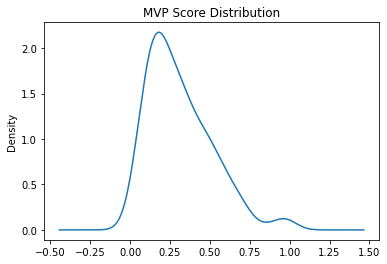

In [422]:
mvptbl['MVP'].plot.kde(title = "MVP Score Distribution")

In [426]:
np.std(mvptbl['MVP'])

0.20119387097293592

In [431]:
v = [0, 3, 10,45,68,95]
PT1.iloc[:,v].head(10).to_excel('data.xlsx')